FINAL TOTAL REWARD: 17.0
Some learned state values: {(2, 3, 1, 3): np.float64(1.5714285714285714), (2, 2, 1, 4): np.float64(2.04), (2, 3, 2, 4): np.float64(5.2), (2, 2, 2, 4): np.float64(5.0), (2, 2, 3, 5): np.float64(23.08)}
Some policy actions: {(2, 3, 1, 3): np.int64(0), (2, 2, 1, 4): np.int64(1), (2, 3, 2, 4): np.int64(0), (2, 2, 2, 4): np.int64(0), (2, 2, 3, 5): np.int64(0)}


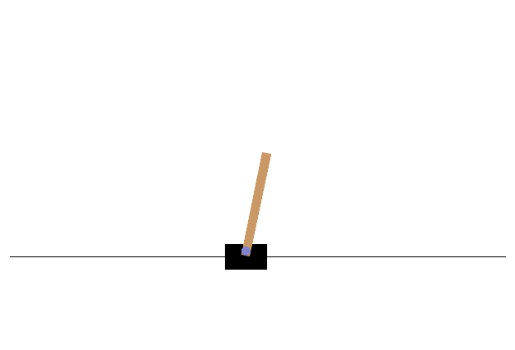

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Create environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Discretization function for continuous state
def discretize(obs, bins=(6, 12)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)))
    cart_vel_bin = int(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[0]-1)))
    pole_angle_bin = int(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[1]-1)))
    pole_vel_bin = int(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[1]-1)))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# Monte Carlo parameters
num_episodes = 500
gamma = 1.0  # discount factor
bins = (6, 12)

# Initialize value table, returns, and policy
V = {}
returns = {}
policy = {}

for episode in range(num_episodes):
    obs, info = env.reset(seed=None)
    done = False
    episode_states = []
    episode_actions = []
    episode_rewards = []

    # Generate an episode
    while not done:
        state = discretize(obs, bins)
        # Epsilon-greedy for exploration
        if state not in policy or np.random.rand() < 0.1:
            action = env.action_space.sample()
        else:
            action = policy[state]

        # Save state, action, reward
        episode_states.append(state)
        episode_actions.append(action)

        obs, reward, terminated, truncated, info = env.step(action)
        episode_rewards.append(reward)
        done = terminated or truncated

    # Calculate returns (first-visit Monte Carlo)
    G = 0
    for t in reversed(range(len(episode_states))):
        G = gamma * G + episode_rewards[t]
        state = episode_states[t]
        action_taken = episode_actions[t]
        if state not in episode_states[:t]:  # first-visit
            if state not in returns:
                returns[state] = []
            returns[state].append(G)
            V[state] = np.mean(returns[state])
            policy[state] = action_taken  # store action, not state

# Test the learned policy
obs, info = env.reset(seed=100)
done = False
total_reward = 0

plt.ion()
fig, ax = plt.subplots()
step = 0

while not done and step < 300:
    frame = env.render()
    ax.imshow(frame)
    ax.axis("off")
    clear_output(wait=True)
    display(fig)

    state = discretize(obs, bins)
    if state in policy:
        action = policy[state]
    else:
        action = env.action_space.sample()

    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated
    step += 1
    time.sleep(0.03)

env.close()
plt.ioff()
clear_output(wait=True)

print("FINAL TOTAL REWARD:", total_reward)
print("Some learned state values:", {k: V[k] for k in list(V)[:5]})
print("Some policy actions:", {k: policy[k] for k in list(policy)[:5]})


FINAL TOTAL REWARD: 2.0


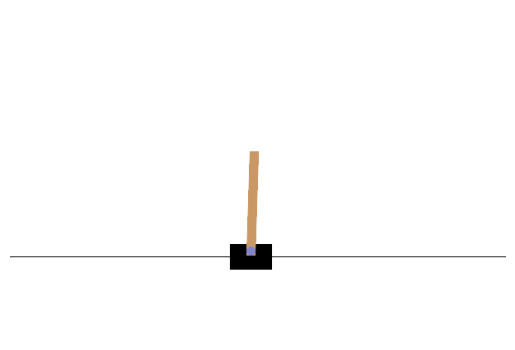

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import math
import random

# ----------- Environment -----------
env = gym.make("CartPole-v1", render_mode="rgb_array")

# ----------- Discretization function -----------
def discretize(obs, bins=(6, 12)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)))
    cart_vel_bin = int(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[0]-1)))
    pole_angle_bin = int(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[1]-1)))
    pole_vel_bin = int(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[1]-1)))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# ----------- MCTS Node -----------
class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = {}  # action: child node
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [0, 1]  # left, right

    def q(self):
        return self.total_reward / self.visits if self.visits > 0 else 0

# ----------- MCTS Algorithm -----------
def ucb(node, child, c=1.4):
    if child.visits == 0:
        return float('inf')
    return child.q() + c * math.sqrt(math.log(node.visits) / child.visits)

def mcts_search(env, root_state, iterations=100, rollout_depth=15):
    root = Node(root_state)

    for _ in range(iterations):
        node = root
        obs_copy = env.reset()[0]  # reset env
        obs_copy[:] = root_state  # approximate current state

        # ----- SELECTION -----
        while node.untried_actions == [] and node.children != {}:
            # pick child with highest UCB
            action, node = max(node.children.items(), key=lambda item: ucb(node, item[1]))
            obs_copy, reward, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                break

        # ----- EXPANSION -----
        if node.untried_actions != []:
            action = node.untried_actions.pop()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            child_state = discretize(obs_copy)
            child_node = Node(child_state, parent=node)
            node.children[action] = child_node
            node = child_node

        # ----- SIMULATION / ROLLOUT -----
        total_reward = 0
        for _ in range(rollout_depth):
            action = env.action_space.sample()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break

        # ----- BACKPROPAGATION -----
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent

    # ----- SELECT BEST ACTION FROM ROOT -----
    best_action = max(root.children.items(), key=lambda item: item[1].q())[0]
    return best_action

# ----------- Test MCTS in CartPole -----------
obs, info = env.reset(seed=100)
done = False
plt.ion()
fig, ax = plt.subplots()
total_reward = 0
step = 0

while not done and step < 300:
    frame = env.render()
    ax.imshow(frame)
    ax.axis("off")
    clear_output(wait=True)
    display(fig)

    state = discretize(obs)
    action = mcts_search(env, state, iterations=50, rollout_depth=10)

    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated
    step += 1
    time.sleep(0.03)

env.close()
plt.ioff()
clear_output(wait=True)

print("FINAL TOTAL REWARD:", total_reward)


In [3]:
!python3 -m pip install networkx


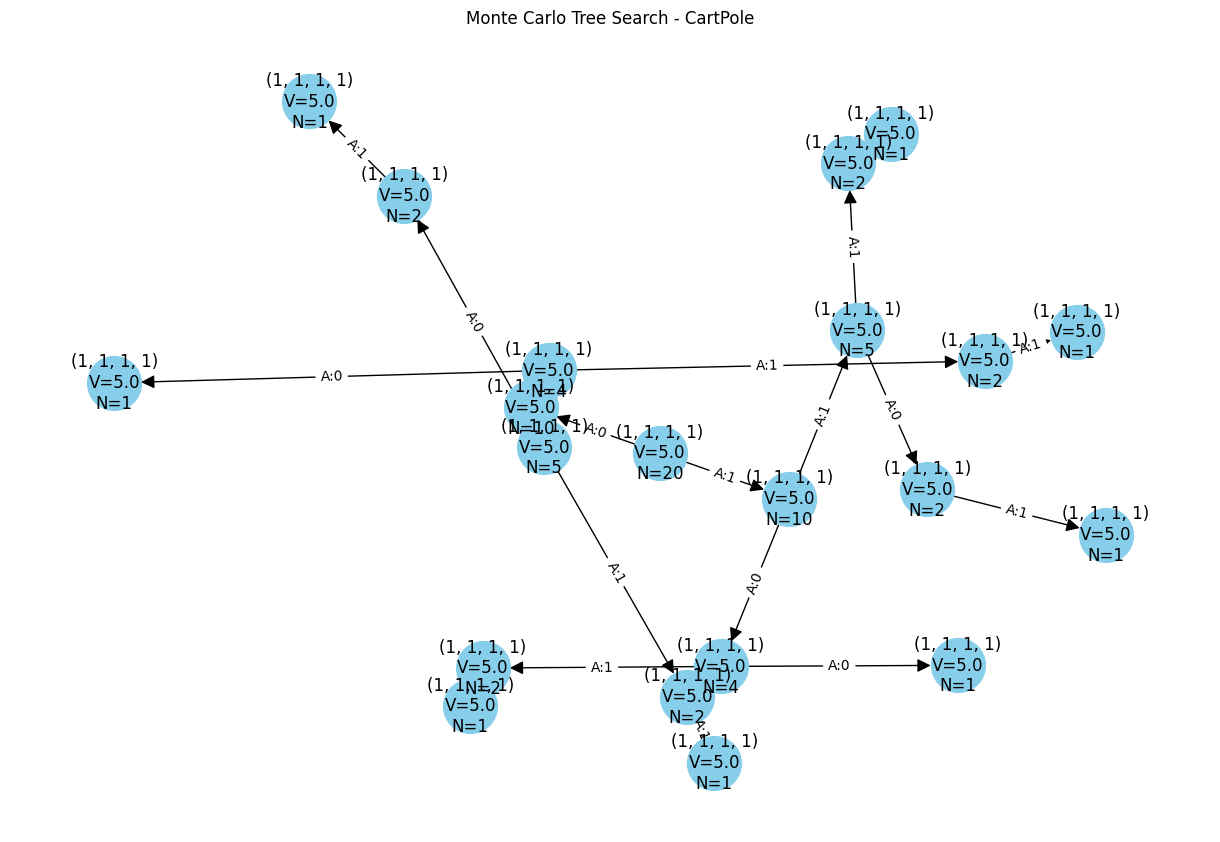

In [10]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math

# ----------- Discretization -----------
def discretize(obs, bins=(3,3,3,3)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)))
    cart_vel_bin = int(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[1]-1)))
    pole_angle_bin = int(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[2]-1)))
    pole_vel_bin = int(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[3]-1)))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# ----------- Node Class -----------
class Node:
    def __init__(self, state, parent=None, action_from_parent=None):
        self.state = state
        self.parent = parent
        self.children = {}  # action: child node
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [0,1]  # left, right
        self.action_from_parent = action_from_parent

    def q(self):
        return self.total_reward / self.visits if self.visits > 0 else 0

# ----------- UCB Function -----------
def ucb(node, child, c=1.4):
    if child.visits == 0:
        return float('inf')
    return child.q() + c * math.sqrt(math.log(node.visits) / child.visits)

# ----------- MCTS Algorithm -----------
def mcts_search(env, root_state, iterations=30, rollout_depth=10):
    root = Node(root_state)

    for _ in range(iterations):
        node = root
        obs_copy, _ = env.reset()
        obs_copy[:] = root_state

        # ----- Selection -----
        while node.untried_actions == [] and node.children != {}:
            action, node = max(node.children.items(), key=lambda item: ucb(node, item[1]))
            obs_copy, reward, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                break

        # ----- Expansion -----
        if node.untried_actions != []:
            action = node.untried_actions.pop()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            child_state = discretize(obs_copy)
            child_node = Node(child_state, parent=node, action_from_parent=action)
            node.children[action] = child_node
            node = child_node

        # ----- Rollout -----
        total_reward = 0
        for _ in range(rollout_depth):
            action = env.action_space.sample()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break

        # ----- Backpropagation -----
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent

    return root

# ----------- Build NetworkX Graph for visualization -----------
def build_graph(root):
    G = nx.DiGraph()
    labels = {}

    def add_node(node):
        node_id = id(node)
        labels[node_id] = f"{node.state}\nV={node.q():.1f}\nN={node.visits}"
        G.add_node(node_id)
        if node.parent:
            G.add_edge(id(node.parent), node_id, label=f"A:{node.action_from_parent}")
        for child in node.children.values():
            add_node(child)

    add_node(root)
    return G, labels

# ----------- Visualize Graph -----------

def visualize_tree(G, labels):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12,8))
    nx.draw(G, pos, with_labels=False, node_size=1500, node_color='skyblue', arrowsize=20)
    nx.draw_networkx_labels(G, pos, labels)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Monte Carlo Tree Search - CartPole")
    plt.show()

# ----------- Run MCTS and visualize -----------

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, _ = env.reset(seed=42)
state = discretize(obs)

root = mcts_search(env, state, iterations=20, rollout_depth=5)
G, labels = build_graph(root)
visualize_tree(G, labels)


In [5]:
!python3 -m pip install networkx


In [6]:
!{sys.executable} -m pip install networkx


zsh:1: parse error near `-m'


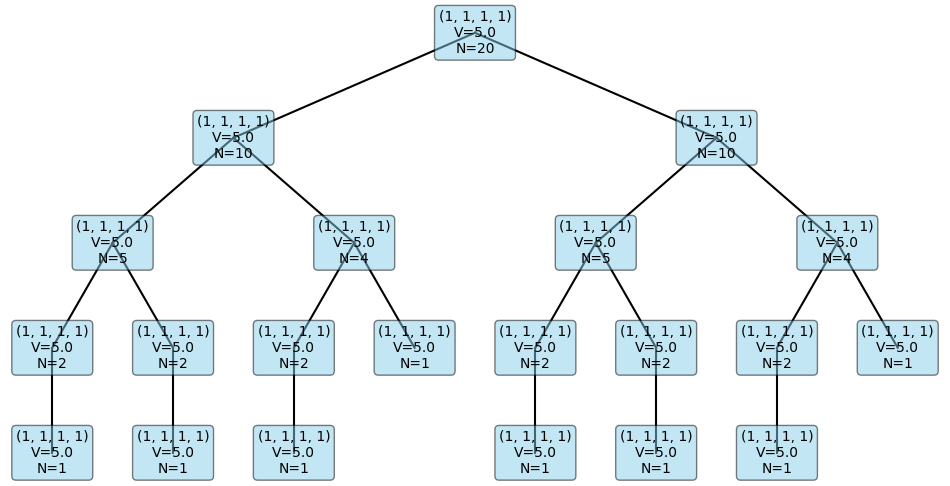

In [11]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# ----------- Discretization -----------
def discretize(obs, bins=(3,3,3,3)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)))
    cart_vel_bin = int(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[1]-1)))
    pole_angle_bin = int(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[2]-1)))
    pole_vel_bin = int(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[3]-1)))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# ----------- Node Class -----------
class Node:
    def __init__(self, state, parent=None, action_from_parent=None):
        self.state = state
        self.parent = parent
        self.children = {}  # action: child node
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [0,1]
        self.action_from_parent = action_from_parent

    def q(self):
        return self.total_reward / self.visits if self.visits > 0 else 0

# ----------- UCB Function -----------
def ucb(node, child, c=1.4):
    if child.visits == 0:
        return float('inf')
    return child.q() + c * math.sqrt(math.log(node.visits) / child.visits)

# ----------- Simple MCTS for Visualization -----------
def mcts_tree(env, root_state, iterations=20, rollout_depth=5):
    root = Node(root_state)

    for _ in range(iterations):
        node = root
        obs_copy, _ = env.reset()
        obs_copy[:] = root_state

        # Selection
        while node.untried_actions == [] and node.children != {}:
            action, node = max(node.children.items(), key=lambda item: ucb(node, item[1]))
            obs_copy, reward, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                break

        # Expansion
        if node.untried_actions != []:
            action = node.untried_actions.pop()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            child_state = discretize(obs_copy)
            child_node = Node(child_state, parent=node, action_from_parent=action)
            node.children[action] = child_node
            node = child_node

        # Rollout
        total_reward = 0
        for _ in range(rollout_depth):
            action = env.action_space.sample()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break

        # Backpropagation
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent

    return root

# ----------- Tree Visualization with Matplotlib -----------
def draw_tree(node, x=0, y=0, dx=1, dy=-1, ax=None, level=0, pos_dict=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
        pos_dict = {}
    pos_dict[node] = (x, y)
    ax.text(x, y, f"{node.state}\nV={node.q():.1f}\nN={node.visits}", ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='skyblue', alpha=0.5))
    num_children = len(node.children)
    if num_children > 0:
        step = dx / num_children
        start_x = x - dx/2 + step/2
        for i, child in enumerate(node.children.values()):
            child_x = start_x + i*step
            child_y = y + dy
            ax.plot([x, child_x], [y, child_y], 'k-')
            draw_tree(child, x=child_x, y=child_y, dx=dx/num_children, dy=dy, ax=ax, level=level+1, pos_dict=pos_dict)
    if level == 0:
        ax.axis('off')
        plt.show()

# ----------- Run MCTS and Draw Tree -----------
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, _ = env.reset(seed=42)
state = discretize(obs)

root = mcts_tree(env, state, iterations=20, rollout_depth=5)
draw_tree(root)


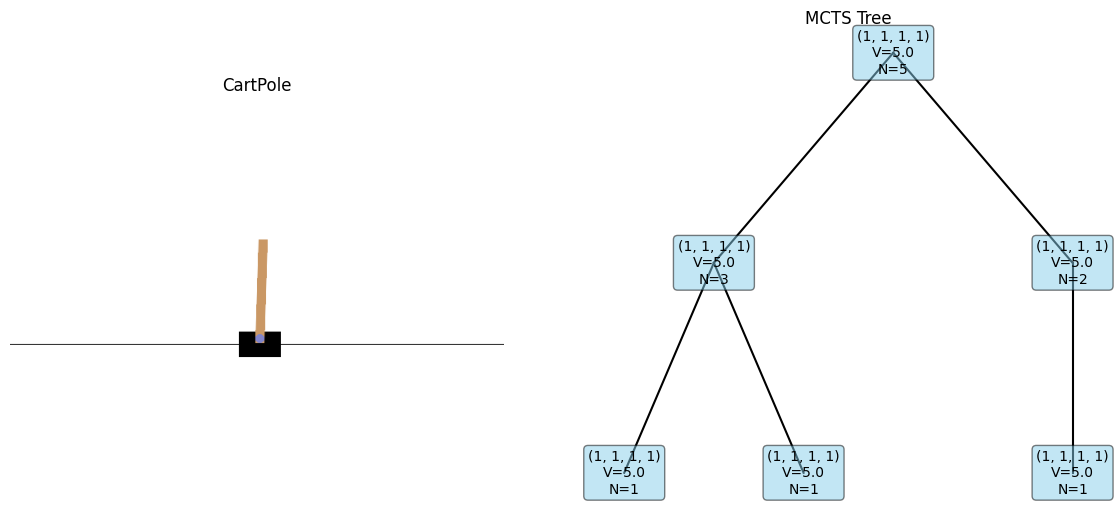

FINAL TOTAL REWARD: 200.0


In [12]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# ----------- Discretization -----------
def discretize(obs, bins=(3,3,3,3)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)))
    cart_vel_bin = int(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[1]-1)))
    pole_angle_bin = int(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[2]-1)))
    pole_vel_bin = int(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[3]-1)))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# ----------- Node Class -----------
class Node:
    def __init__(self, state, parent=None, action_from_parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [0,1]
        self.action_from_parent = action_from_parent
    def q(self):
        return self.total_reward / self.visits if self.visits>0 else 0

# ----------- UCB Function -----------
def ucb(node, child, c=1.4):
    if child.visits == 0:
        return float('inf')
    return child.q() + c * math.sqrt(math.log(node.visits)/child.visits)

# ----------- MCTS for single step -----------
def mcts_tree_step(env, root_state, iterations=10, rollout_depth=5):
    root = Node(root_state)
    for _ in range(iterations):
        node = root
        obs_copy, _ = env.reset()
        obs_copy[:] = root_state

        # Selection
        while node.untried_actions==[] and node.children!={}:
            action, node = max(node.children.items(), key=lambda item: ucb(node, item[1]))
            obs_copy, reward, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                break

        # Expansion
        if node.untried_actions!=[]:
            action = node.untried_actions.pop()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            child_state = discretize(obs_copy)
            child_node = Node(child_state, parent=node, action_from_parent=action)
            node.children[action]=child_node
            node = child_node

        # Rollout
        total_reward=0
        for _ in range(rollout_depth):
            action = env.action_space.sample()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            total_reward+=reward
            if terminated or truncated:
                break

        # Backprop
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent
    # Choose best action
    if root.children:
        best_action = max(root.children.items(), key=lambda item: item[1].q())[0]
    else:
        best_action = env.action_space.sample()
    return best_action, root

# ----------- Draw tree -----------
def draw_tree(node, x=0, y=0, dx=1, dy=-1, ax=None, level=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
    ax.text(x, y, f"{node.state}\nV={node.q():.1f}\nN={node.visits}", ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='skyblue', alpha=0.5))
    num_children = len(node.children)
    if num_children>0:
        step = dx/num_children
        start_x = x - dx/2 + step/2
        for i, child in enumerate(node.children.values()):
            child_x = start_x + i*step
            child_y = y + dy
            ax.plot([x, child_x], [y, child_y], 'k-')
            draw_tree(child, x=child_x, y=child_y, dx=dx/num_children, dy=dy, ax=ax, level=level+1)
    if level==0:
        ax.axis('off')
        return ax

# ----------- Run CartPole with MCTS & tree -----------
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, _ = env.reset(seed=42)
done=False
total_reward=0
plt.ion()
fig, ax = plt.subplots(1,2, figsize=(14,6))

step=0
while not done and step<200:
    # --- Render CartPole ---
    frame = env.render()
    ax[0].imshow(frame)
    ax[0].axis('off')
    ax[0].set_title("CartPole")

    # --- Run MCTS step ---
    state = discretize(obs)
    action, root = mcts_tree_step(env, state, iterations=5, rollout_depth=5)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated

    # --- Draw tree ---
    ax[1].cla()
    draw_tree(root, ax=ax[1])
    ax[1].set_title("MCTS Tree")
    
    plt.pause(0.1)
    step+=1

env.close()
plt.ioff()
plt.show()
print("FINAL TOTAL REWARD:", total_reward)


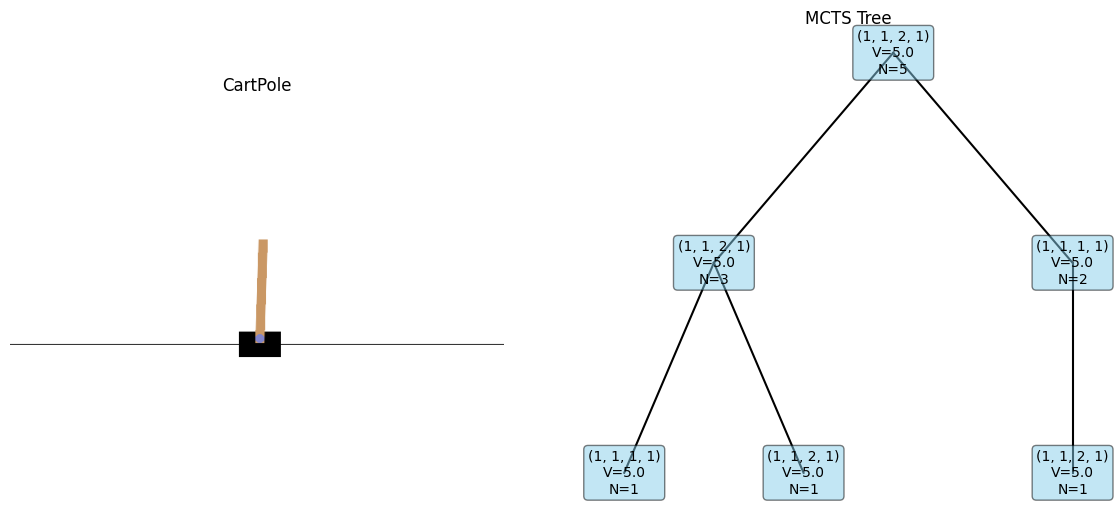

FINAL TOTAL REWARD: 200.0


In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress pygame pkg_resources warning

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# ----------- Discretization -----------
def discretize(obs, bins=(3,2,4,3)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)))
    cart_vel_bin = int(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[1]-1)))
    pole_angle_bin = int(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[2]-1)))
    pole_vel_bin = int(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[3]-1)))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# ----------- Node Class -----------
class Node:
    def __init__(self, state, parent=None, action_from_parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [0,1]
        self.action_from_parent = action_from_parent
    def q(self):
        return self.total_reward / self.visits if self.visits>0 else 0

# ----------- UCB Function -----------
def ucb(node, child, c=1.4):
    if child.visits == 0:
        return float('inf')
    return child.q() + c * math.sqrt(math.log(node.visits)/child.visits)

# ----------- MCTS for single step -----------
def mcts_tree_step(env, root_state, iterations=5, rollout_depth=5):
    root = Node(root_state)
    for _ in range(iterations):
        node = root
        obs_copy, _ = env.reset()
        obs_copy[:] = root_state

        # Selection
        while node.untried_actions==[] and node.children!={}:
            action, node = max(node.children.items(), key=lambda item: ucb(node, item[1]))
            obs_copy, reward, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                break

        # Expansion
        if node.untried_actions!=[]:
            action = node.untried_actions.pop()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            child_state = discretize(obs_copy)
            child_node = Node(child_state, parent=node, action_from_parent=action)
            node.children[action]=child_node
            node = child_node

        # Rollout
        total_reward=0
        for _ in range(rollout_depth):
            action = env.action_space.sample()
            obs_copy, reward, terminated, truncated, info = env.step(action)
            total_reward+=reward
            if terminated or truncated:
                break

        # Backprop
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent
    # Choose best action
    if root.children:
        best_action = max(root.children.items(), key=lambda item: item[1].q())[0]
    else:
        best_action = env.action_space.sample()
    return best_action, root

# ----------- Draw tree -----------
def draw_tree(node, x=0, y=0, dx=1, dy=-1, ax=None, level=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
    ax.text(x, y, f"{node.state}\nV={node.q():.1f}\nN={node.visits}", ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='skyblue', alpha=0.5))
    num_children = len(node.children)
    if num_children>0:
        step = dx/num_children
        start_x = x - dx/2 + step/2
        for i, child in enumerate(node.children.values()):
            child_x = start_x + i*step
            child_y = y + dy
            ax.plot([x, child_x], [y, child_y], 'k-')
            draw_tree(child, x=child_x, y=child_y, dx=dx/num_children, dy=dy, ax=ax, level=level+1)
    if level==0:
        ax.axis('off')
        return ax

# ----------- Run CartPole with MCTS & tree -----------
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, _ = env.reset(seed=42)
done=False
total_reward=0
plt.ion()
fig, ax = plt.subplots(1,2, figsize=(14,6))

step=0
while not done and step<200:
    # --- Render CartPole ---
    frame = env.render()
    ax[0].imshow(frame)
    ax[0].axis('off')
    ax[0].set_title("CartPole")

    # --- Run MCTS step ---
    state = discretize(obs)
    action, root = mcts_tree_step(env, state, iterations=5, rollout_depth=5)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated

    # --- Draw tree ---
    ax[1].cla()
    draw_tree(root, ax=ax[1])
    ax[1].set_title("MCTS Tree")
    
    plt.pause(0.1)
    step+=1

env.close()
plt.ioff()
plt.show()
print("FINAL TOTAL REWARD:", total_reward)


Simulated total reward (root node): 2245.0


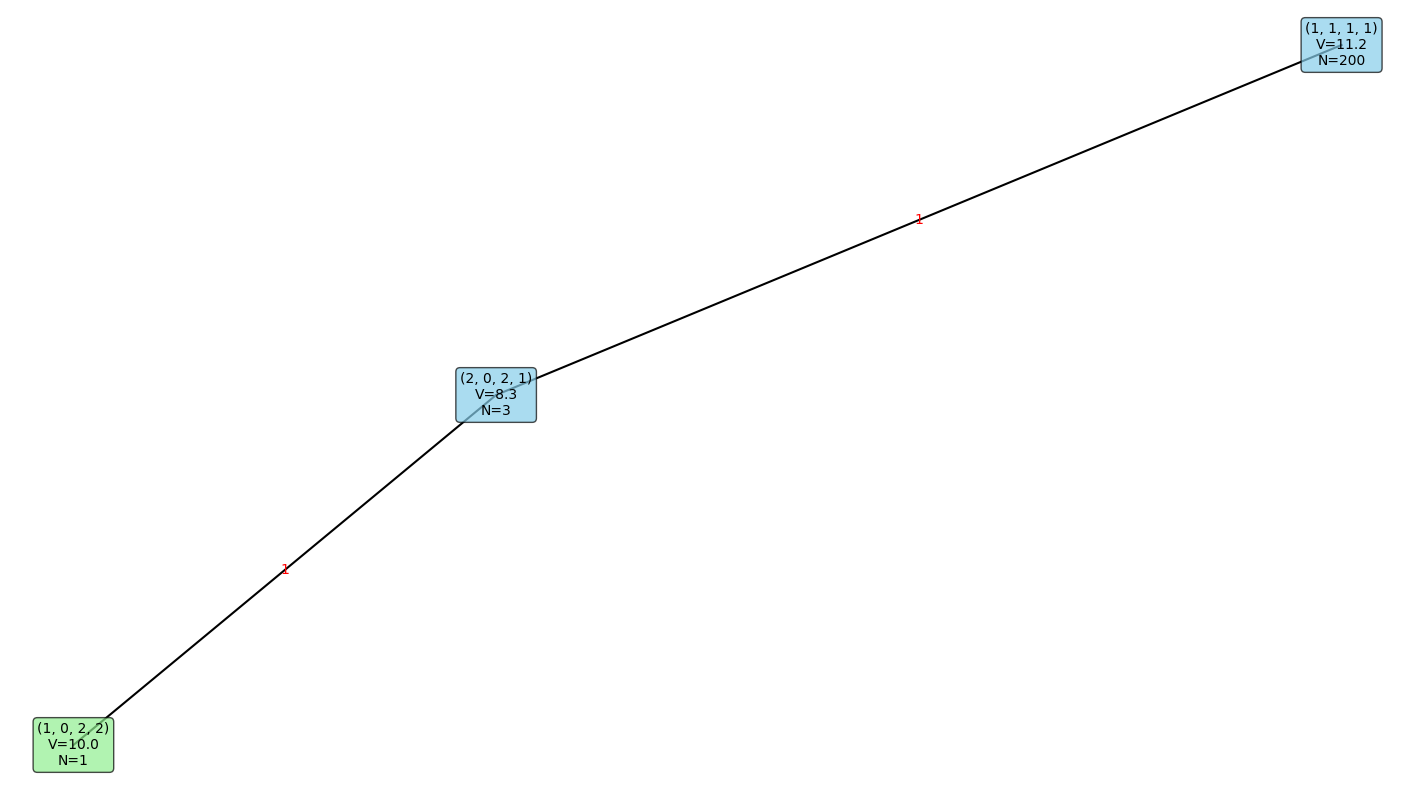

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# ---------------- Discretization ----------------
def discretize(obs, bins=(3,2,4,3)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)))
    cart_vel_bin = int(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[1]-1)))
    pole_angle_bin = int(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[2]-1)))
    pole_vel_bin = int(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[3]-1)))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# ---------------- Node Class ----------------
class Node:
    def __init__(self, state, parent=None, action_from_parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [0,1]
        self.action_from_parent = action_from_parent

    def q(self):
        return self.total_reward / self.visits if self.visits > 0 else 0

# ---------------- UCB ----------------
def ucb(node, child, c=1.4):
    if child.visits == 0:
        return float('inf')
    return child.q() + c * math.sqrt(math.log(node.visits)/child.visits)

# ---------------- MCTS Simulation ----------------
def mcts_simulate(root, iterations=200, rollout_depth=5):
    for _ in range(iterations):
        node = root

        # ----- Selection -----
        while node.untried_actions == [] and node.children != {}:
            action, node = max(node.children.items(), key=lambda item: ucb(node, item[1]))

        # ----- Expansion -----
        if node.untried_actions != []:
            action = node.untried_actions.pop()
            # simulate child state
            child_state = tuple([min(b-1, max(0, s+random.randint(-1,1))) for s,b in zip(node.state,(3,2,4,3))])
            if action not in node.children:
                node.children[action] = Node(child_state, parent=node, action_from_parent=action)
            node = node.children[action]

        # ----- Rollout -----
        total_reward = 0
        for _ in range(rollout_depth):
            # reward: better if pole bin near middle
            pole_bin = node.state[2]
            reward = max(0, 3 - abs(pole_bin - 1))
            total_reward += reward

        # ----- Backpropagation -----
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent

    # best action
    if root.children:
        best_action = max(root.children.items(), key=lambda item: item[1].q())[0]
    else:
        best_action = 0

    # total reward at root
    total_reward_root = root.total_reward
    return root, best_action, total_reward_root

# ---------------- Draw Tree Properly ----------------
def draw_tree(node, x=0, y=0, dx=8, dy=-3, ax=None, best_action=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(18,10))

    # highlight best child
    color = 'lightgreen' if node.action_from_parent == best_action else 'skyblue'
    ax.text(x, y, f"{node.state}\nV={node.q():.1f}\nN={node.visits}",
            ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7))

    num_children = len(node.children)
    if num_children>0:
        step = dx / num_children
        start_x = x - dx/2 + step/2
        best_child = max(node.children.items(), key=lambda item: item[1].q())[0]
        for i, (action, child) in enumerate(node.children.items()):
            child_x = start_x + i*step
            child_y = y + dy
            ax.plot([x, child_x], [y, child_y], 'k-')
            mid_x = (x + child_x)/2
            mid_y = (y + child_y)/2
            ax.text(mid_x, mid_y, str(action), color='red', fontsize=10, ha='center', va='center')
            draw_tree(child, x=child_x, y=child_y, dx=dx/num_children, dy=dy, ax=ax, best_action=best_child)

    ax.axis('off')
    plt.show()

# ---------------- Run MCTS ----------------
root_state = (1,1,1,1)  # starting discretized state
root = Node(root_state)

root, best_action, total_reward = mcts_simulate(root, iterations=200, rollout_depth=5)
print("Simulated total reward (root node):", total_reward)
draw_tree(root, best_action=best_action)
